
# ME 5984 Applied Machine Learning, Assignment 2: Regression
-----

In this assignment, you will attempt to identify a regressor that performs the best (using cross validation) on the California housing data set. Instead of using the example code I provided earlier, you will use Scikit-Learn's curated version of the data as the starting point.  
The goal of this assignment is to have you gain experience in trying a variety of methods to identify the best regressor for a possibly modified data set. Your score will be based on the effort, and not on exact CV scores or exceeding a minimum score threshold.  
Copy the following code into your notebook to get started.

In [ ]:
from helper import *
from sklearn.datasets import fetch_california_housing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X,y = fetch_california_housing(return_X_y=True)
Xs,ys = shuffle(X, y, random_state=5984)
Xstrain, Xstest, Ystrain, Ystest = train_test_split(Xs, ys, test_size=0.2)

You have now created standardized training and test sets that will be consistent among submissions. Set the test sets aside and do not use them again except where specically noted.

## 1. Problem 1

Using *regression methods that you already learned about*, try to find a regressor that maximizes the cross validation score over 5 folds, where the regressor and training sets in the example below are stand-ins for regressors and set you provide. For example, if you not using a method such as `GridSearchCV` which implements cross validation internally, you may evaluate it specically via:

`from sklearn.model_selection import cross_val_score`  
`cv_scores = cross_val_score(regressor_, X_training_, y_training_, cv=5)`    
`cv_mean_score = np.mean(cv_scores)`


Create pipelines that use StandardScaler as a first step. Based on how you choose to modify features and perform hyperparameter searches, your pipeline may grow to include more.  
Choose from the following regression methods:
* `LinearRegression`  
* `Ridge`  
* `Lasso` and/or `LassoLars` 
* `ElasticNet`
* `DecisionTreeRegressor`

Choose from the following methods for modifying the feature vectors for use in the regression methods:  
*   `PolynomialFeatures` for creating  vectors  
*   `RFE`, which implements a variation of backward stepwise subset selection  
*   `VarianceThreshold` for removing features with low variance  
*   `SelectKBest` for choosing the K best features with highest scores
*   Hand-made additional features, such as the "bedrooms per room" feature from the example

Choose from the following methods for generating a search for optimal hyperparameters (Note: these methods implement cross validation internally): 
*   `GridSearchCV`
*   `RandomizedSearchCV`

**Tip**: utilize the documentation provided by scikit-learn as much as possible to better understand these methods, their parameters, and how to best utilize them.  
`https://scikit-learn.org/stable/supervised_learning.html`

You may also use other regressors, feature modications, and search methods besides those listed above.

-----
### 1.1 Analysis

Report the best combination of regression methods, feature modications, and hyperparameters as a function of the average CV score on the training set using 5-fold cross validation. Compare the best combination's CV score to the score on the test set. Describe what you tried, what you observed, and the insights you may have gained from those trials that led you to discovering the best combination.  
Do not use the test set for any part of the hyperparameter search and training above.  
You will be scored based on the thoroughness of your search and effort.
Trying just one method without modifying any hyperparameters, for example, is low effort and will be scored as such. Trying several methods with some kind of search over the hyperparameter space, and trying feature modications for example, will likely result in a higher CV score and will definitely result in a higher score on this problem. There is not a minimum threshold for CV score that will be checked.

In [ ]:
## Import libraries
import time
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import randint

---
### 1.1.1 Data set Preparation

> First we take a look at the data set and plot the features separately to get a feel for the data set and then check if the there is any `NaN` entries in the data set.

In [ ]:
## Extract feature names
housing = fetch_california_housing()
feature_names = housing.feature_names
housing = pd.DataFrame(data=housing, columns=feature_names)

## Assign feature names to the columns of Xstrain, and Xstest
Xstrain_df = pd.DataFrame(data=Xstrain, columns=feature_names)
Xstest_df = pd.DataFrame(data=Xstest, columns=feature_names)
print("Ystrain =", Ystrain, "\n")
Xstrain_df.head()

Ystrain = [0.996 2.349 0.485 ... 3.493 0.619 3.854] 



,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,1.9074,37.0,4.098662,1.117057,2824.0,4.722408,34.01,-118.26
1,5.3889,33.0,6.078880,1.043257,1229.0,3.127226,33.86,-118.11
2,2.2167,18.0,3.782468,1.084416,1119.0,3.633117,36.01,-120.12
3,7.5557,36.0,7.743396,1.083019,699.0,2.637736,32.73,-117.23
4,3.9038,21.0,3.586357,0.982583,1486.0,2.156749,37.36,-122.02


In [ ]:
## No of NaN entries
print("No. of NaN entries:\n" + 19*"="); housing.isnull().sum()

No. of NaN entries:


MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

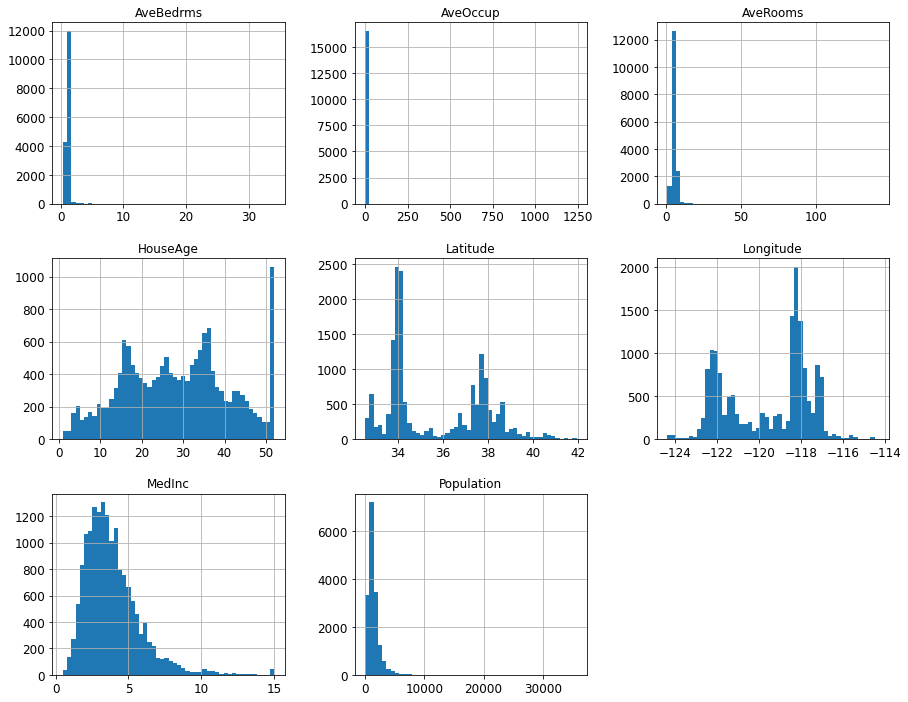

In [ ]:
## Plot histograms of features
Xstrain_df.hist(bins=50, figsize=(15, 12))
fig = plt.gcf()
plt.show()

> As we can see, the `Y` vectors are not in `$` and the data set doesn't have any missing value. The spikes at the end of the range for `HouseAge` and `MdeInc` show that they are capped and the values indicate data was pre-scaled.  Needless to say, the variablity is very different across the features.  
For now we don't add any new feature to our data set and try to reduce the prediction error by tuning the parameters as much as possible.

-----
### 1.1.2 Regression Models

> We run all the aforementioned regressors plus `RandomForestRegressor` using two or more of the methods for modifying the features and store the errors and useful parameters to compare the regressors in the end.

In [ ]:
## Best regressors' MSE and MAE
best_regressors = []
best_regressors_cr = {}

In [ ]:
## Helper functions
def get_best_parameters(grid_search_fit):
  parameters = grid_search_fit.best_params_  
  for key in parameters: 
    print("{} = {}".format(key, parameters[key]))

def get_regressor_name(regressor):
  try:
    regressor_name = str(type(regressor.named_steps.reg)).split(".")[-1][:-2]
    if regressor_name in ["Ridge", "Lasso", "LassoLars"]:
      regressor_name = "".join([regressor_name, "Regressor"])
    return regressor_name

  except AttributeError:
    if str(type(regressor)).split(".")[-1][:-2] == "RandomizedSearchCV":
      regressor_name = "RandomForestRegressor"
      return regressor_name

warnings.simplefilter('ignore')

-----
#### 1.1.2.1 Linear Regression

> We run `LinearRegression`, having added the `PolynomialFeatures` and `SelectKBest` (including all features = 8) methods to the pipeline for feature selection.

In [ ]:
## Linear Regression
lin_reg_start_time = time.perf_counter()
lin_reg = Pipeline([("poly", PolynomialFeatures()),
                    ("scaler", StandardScaler()),
                    ("sk", SelectKBest(score_func=f_regression)),
                    ("reg", LinearRegression())])
lin_reg_param_grid = {"poly__degree": [2, 3],
                      "sk__k": [2, 4, 6, 8]}
lin_reg_grid_search = GridSearchCV(lin_reg, lin_reg_param_grid, cv=5,
                                     scoring='neg_mean_squared_error', return_train_score=True)
lin_reg_grid_search_fit = lin_reg_grid_search.fit(Xstrain, Ystrain)
lin_reg_grid_search_fit_best = lin_reg_grid_search_fit.best_estimator_
best_regressors.append(lin_reg_grid_search_fit_best)

# Predict
lin_reg_grid_search_pred = lin_reg_grid_search_fit_best.predict(Xstest)
lin_reg_grid_search_pred_mse = mean_squared_error(Ystest, lin_reg_grid_search_pred)
lin_reg_grid_search_pred_rmse = np.sqrt(lin_reg_grid_search_pred_mse)
lin_reg_grid_search_pred_mae = mean_absolute_error(Ystest, lin_reg_grid_search_pred)
lin_reg_grid_search_pred_r2 = r2_score(Ystest, lin_reg_grid_search_pred)
lin_reg_compute_time = time.perf_counter() - lin_reg_start_time

# Save the errors for final regression model comparisons
best_regressors_cr["Linear"] = [lin_reg_grid_search_pred_rmse,
                                lin_reg_grid_search_pred_mse,
                                lin_reg_grid_search_pred_mae,
                                lin_reg_grid_search_pred_r2,
                                lin_reg_grid_search_fit.best_params_["poly__degree"],
                                lin_reg_grid_search_fit.best_params_["sk__k"],
                                "-", "-", lin_reg_compute_time]

# Report results
print("Best Parameters:\n"+ 16*"="); get_best_parameters(lin_reg_grid_search_fit)
print(24*"=" + "\nComputation time = %1.3f\n" %lin_reg_compute_time + 31*"=")
print("Linear Regression RMSE = %.4f" %lin_reg_grid_search_pred_rmse)
print("Linear Regression MSE  = %.4f" %lin_reg_grid_search_pred_mse)
print("Linear Regression MAE  = %.4f" %lin_reg_grid_search_pred_mae); print(31*"=")
print("mean train CV score = \n{}".format(lin_reg_grid_search.cv_results_["mean_train_score"]))
print("\nmean test CV score  = \n{}".format(lin_reg_grid_search.cv_results_["mean_test_score"]))
print(72*"=" + "\nBest Estimator:\n"); lin_reg_grid_search_fit_best

Best Parameters:
poly__degree = 2
sk__k = 6
Computation time = 5.535
Linear Regression RMSE = 0.7120
Linear Regression MSE  = 0.5070
Linear Regression MAE  = 0.5243
mean train CV score = 
[-0.70512106 -0.54774165 -0.53022399 -0.52400737 -0.7051312  -0.55563969
 -0.54753229 -0.53657062]

mean test CV score  = 
[-0.70546132 -0.54824854 -0.53190686 -0.53318228 -0.70547002 -0.55614551
 -0.54826078 -0.53752899]
Best Estimator:



Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sk',
                 SelectKBest(k=6,
                             score_func=<function f_regression at 0x000001A19CEA5B88>)),
                ('reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

> The mean CV scores for the `train` and `test` sets are very close and shows that we are not overfitting.

-----
#### 1.1.2.2 Ridge Regression

> We run `Ridge` regression, having added the `PolynomialFeatures` and `SelectKBest` methods to the pipeline for feature selection  ||`GridSearchCV`||.

In [ ]:
## Ridge Regression
ridge_reg_start_time = time.perf_counter()
ridge_reg = Pipeline([("poly", PolynomialFeatures()),
                      ("scaler", StandardScaler()),
                      ("sk", SelectKBest(score_func=f_regression)),
                      ("reg", Ridge())])
ridge_reg_param_grid = {"reg__alpha": [100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0],
                        "poly__degree": [2, 3],
                        "sk__k": [2, 4, 6, 8]}
ridge_reg_grid_search = GridSearchCV(ridge_reg, ridge_reg_param_grid, cv=5,
                                     scoring='neg_mean_squared_error', return_train_score=True)
ridge_reg_grid_search_fit = ridge_reg_grid_search.fit(Xstrain, Ystrain)
ridge_reg_grid_search_fit_best = ridge_reg_grid_search_fit.best_estimator_
best_regressors.append(ridge_reg_grid_search_fit_best)

# Predict
ridge_reg_grid_search_pred = ridge_reg_grid_search_fit_best.predict(Xstest)
ridge_reg_grid_search_pred_mse = mean_squared_error(Ystest, ridge_reg_grid_search_pred)
ridge_reg_grid_search_pred_rmse = np.sqrt(ridge_reg_grid_search_pred_mse)
ridge_reg_grid_search_pred_mae = mean_absolute_error(Ystest, ridge_reg_grid_search_pred)
ridge_reg_grid_search_pred_r2 = r2_score(Ystest, ridge_reg_grid_search_pred)
ridge_reg_compute_time = time.perf_counter() - ridge_reg_start_time

# Save the errors for final regression model comparisons
best_regressors_cr["Ridge"] = [ridge_reg_grid_search_pred_rmse,
                               ridge_reg_grid_search_pred_mse, 
                               ridge_reg_grid_search_pred_mae,
                               ridge_reg_grid_search_pred_r2,
                               ridge_reg_grid_search_fit.best_params_["poly__degree"],
                               ridge_reg_grid_search_fit.best_params_["sk__k"],
                               ridge_reg_grid_search_fit.best_params_["reg__alpha"],
                               "-", ridge_reg_compute_time]

# Report results
print("Best Parameters:\n"+ 16*"="); get_best_parameters(ridge_reg_grid_search_fit)
print(25*"=" + "\nComputation time = %1.3f\n" %ridge_reg_compute_time + 30*"=")
print("Ridge Regression RMSE = %.4f" %ridge_reg_grid_search_pred_rmse)
print("Ridge Regression MSE  = %.4f" %ridge_reg_grid_search_pred_mse)
print("Ridge Regression MAE  = %.4f" %ridge_reg_grid_search_pred_mae); print(30*"=")
print("mean train CV score = \n{}".format(ridge_reg_grid_search.cv_results_["mean_train_score"]))
print("\nmean test CV score  = \n{}".format(ridge_reg_grid_search.cv_results_["mean_test_score"]))
print(72*"=" + "\nBest Estimator:\n"); ridge_reg_grid_search_fit_best

Best Parameters:
poly__degree = 2
reg__alpha = 0.01
sk__k = 6
Computation time = 42.863
Ridge Regression RMSE = 0.7120
Ridge Regression MSE  = 0.5070
Ridge Regression MAE  = 0.5244
mean train CV score = 
[-0.70625741 -0.69083193 -0.64282988 -0.62695136 -0.70547997 -0.66117671
 -0.62130046 -0.60768436 -0.70513356 -0.57732236 -0.5572987  -0.5493382
 -0.70512121 -0.54859443 -0.53110533 -0.52484676 -0.70512106 -0.54775151
 -0.53023441 -0.52401734 -0.70512106 -0.54774175 -0.53022409 -0.52400748
 -0.70512106 -0.54774165 -0.53022399 -0.52400738 -0.70512106 -0.54774165
 -0.53022399 -0.52400737 -0.70518343 -0.68662461 -0.67914627 -0.67072254
 -0.70514499 -0.61739686 -0.61002815 -0.60060142 -0.70513168 -0.56033362
 -0.56048993 -0.55151003 -0.70513121 -0.55675129 -0.55653789 -0.54585198
 -0.70513121 -0.55664303 -0.55396636 -0.54355997 -0.7051312  -0.55624911
 -0.55045387 -0.54023213 -0.7051312  -0.55569905 -0.54882989 -0.53831754
 -0.7051312  -0.55563969 -0.54753229 -0.53657062]

mean test CV sco

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sk',
                 SelectKBest(k=6,
                             score_func=<function f_regression at 0x000001A19CEA5B88>)),
                ('reg',
                 Ridge(alpha=0.01, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

> The mean CV scores for the `train` and `test` sets are very close and shows that we are not overfitting.

-----
#### 1.1.2.3 LASSO

> `Lasso` with `PolynomialFeatures` and `SelectKBest` methods for feature selection ||`GridSearchCV`||.

In [ ]:
## LASSO
lasso_reg_start_time = time.perf_counter()
lasso_reg = Pipeline([("poly", PolynomialFeatures()),
                      ("scaler", StandardScaler()),
                      ("sk", SelectKBest(score_func=f_regression)),
                      ("reg", Lasso())])
lasso_reg_param_grid = {"reg__alpha": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0],
                        "poly__degree": [2, 3],
                        "sk__k": [2, 4, 6, 8]}
lasso_reg_grid_search = GridSearchCV(lasso_reg, lasso_reg_param_grid, cv=5,
                                     scoring='neg_mean_squared_error', return_train_score=True)
lasso_reg_grid_search_fit = lasso_reg_grid_search.fit(Xstrain, Ystrain)
lasso_reg_grid_search_fit_best = lasso_reg_grid_search_fit.best_estimator_
best_regressors.append(lasso_reg_grid_search_fit_best)

# Predict
lasso_reg_grid_search_pred = lasso_reg_grid_search_fit_best.predict(Xstest)
lasso_reg_grid_search_pred_mse = mean_squared_error(Ystest, lasso_reg_grid_search_pred)
lasso_reg_grid_search_pred_rmse = np.sqrt(lasso_reg_grid_search_pred_mse)
lasso_reg_grid_search_pred_mae = mean_absolute_error(Ystest, lasso_reg_grid_search_pred)
lasso_reg_grid_search_pred_r2 = r2_score(Ystest, lasso_reg_grid_search_pred)
lasso_reg_compute_time = time.perf_counter() - lasso_reg_start_time

# Save the errors for final regression model comparisons
best_regressors_cr["LASSO"] = [lasso_reg_grid_search_pred_rmse,
                               lasso_reg_grid_search_pred_mse,
                               lasso_reg_grid_search_pred_mae,
                               lasso_reg_grid_search_pred_r2,
                               lasso_reg_grid_search_fit.best_params_["poly__degree"],
                               lasso_reg_grid_search_fit.best_params_["sk__k"],
                               lasso_reg_grid_search_fit.best_params_["reg__alpha"],
                               "-", lasso_reg_compute_time]
# Report results
print("Best Parameters:\n"+ 16*"="); get_best_parameters(lasso_reg_grid_search_fit)
print(25*"=" + "\nComputation_time = %1.3f\n" %lasso_reg_compute_time + 30*"=")
print("LASSO Regression RMSE = %.4f" %lasso_reg_grid_search_pred_rmse)
print("LASSO Regression MSE  = %.4f" %lasso_reg_grid_search_pred_mse)
print("LASSO Regression MAE  = %.4f" %lasso_reg_grid_search_pred_mae); print(30*"=")
print("mean train CV score = \n{}".format(lasso_reg_grid_search.cv_results_["mean_train_score"]))
print("\nmean test CV score  = \n{}".format(lasso_reg_grid_search.cv_results_["mean_test_score"]))
print(72*"=" + "\nBest Estimator:\n"); lasso_reg_grid_search_fit_best

Best Parameters:
poly__degree = 3
reg__alpha = 0
sk__k = 8
Computation_time = 49.855
LASSO Regression RMSE = 0.7504
LASSO Regression MSE  = 0.5631
LASSO Regression MAE  = 0.5562
mean train CV score = 
[-1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595
 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595
 -0.71559919 -0.71559919 -0.67732931 -0.67732931 -0.70569919 -0.70172957
 -0.6542816  -0.63917402 -0.70560019 -0.66068543 -0.62238092 -0.60963539
 -0.70533686 -0.6479926  -0.61238348 -0.60017853 -0.70527653 -0.64660485
 -0.61126925 -0.59912793 -1.33677595 -1.33677595 -1.33677595 -1.33677595
 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595
 -1.33677595 -1.33677595 -0.71513966 -0.71513364 -0.71513364 -0.71513364
 -0.70525592 -0.70524048 -0.68502    -0.67769733 -0.70515904 -0.62554282
 -0.61041193 -0.6014325  -0.70515826 -0.61661615 -0.59974694 -0.5897869
 -0.70515828 -0.61566259 -0.59864089 -0.5884456 ]

mean test CV score 

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sk',
                 SelectKBest(k=8,
                             score_func=<function f_regression at 0x000001A19CEA5B88>)),
                ('reg',
                 Lasso(alpha=0, copy_X=True, fit_intercept=True, max_iter=1000,
                       normalize=False, positive=False, precompute=False,
                       random_state=None, selection='cyclic', tol=0.0001,
                       warm_start=False))],
         verbose=False)

> The mean CV scores for the `train` and `test` sets are very close and shows that we are not overfitting.

-----
#### 1.1.2.4 LARS

> `LassoLars` with `PolynomialFeatures` and `SelectKBest` methods for feature selection ||`GridSearchCV`||.

In [ ]:
## LARS
lassoLars_reg_start_time = time.perf_counter()
lassoLars_reg = Pipeline([("poly", PolynomialFeatures()),
                          ("scaler", StandardScaler()),
                          ("sk", SelectKBest(score_func=f_regression)),
                          ("reg", LassoLars())])
lassoLars_reg_param_grid = {"reg__alpha": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0],
                            "poly__degree": [2, 3],
                            "sk__k": [2, 4, 6, 8]}
lassoLars_reg_grid_search = GridSearchCV(lassoLars_reg, lassoLars_reg_param_grid, cv=5,
                                         scoring='neg_mean_squared_error', return_train_score=True)
lassoLars_reg_grid_search_fit = lassoLars_reg_grid_search.fit(Xstrain, Ystrain)
lassoLars_reg_grid_search_fit_best = lassoLars_reg_grid_search_fit.best_estimator_
best_regressors.append(lassoLars_reg_grid_search_fit_best)

# Predict
lassoLars_reg_grid_search_pred = lassoLars_reg_grid_search_fit_best.predict(Xstest)
lassoLars_reg_grid_search_pred_mse = mean_squared_error(Ystest, lassoLars_reg_grid_search_pred)
lassoLars_reg_grid_search_pred_rmse = np.sqrt(lassoLars_reg_grid_search_pred_mse)
lassoLars_reg_grid_search_pred_mae = mean_absolute_error(Ystest, lassoLars_reg_grid_search_pred)
LassoLars_reg_grid_search_pred_r2 = r2_score(Ystest, lassoLars_reg_grid_search_pred)
lassoLars_reg_compute_time = time.perf_counter() - lassoLars_reg_start_time

# Save the errors for final regression model comparisons
best_regressors_cr["LARS"] = [lassoLars_reg_grid_search_pred_rmse,
                              lassoLars_reg_grid_search_pred_mse,
                              lassoLars_reg_grid_search_pred_mae,
                              LassoLars_reg_grid_search_pred_r2,
                              lassoLars_reg_grid_search_fit.best_params_["poly__degree"],
                              lassoLars_reg_grid_search_fit.best_params_["sk__k"],
                              lassoLars_reg_grid_search_fit.best_params_["reg__alpha"],
                              "-", lassoLars_reg_compute_time]

# Report results
print("Best Parameters:\n"+ 16*"="); get_best_parameters(lassoLars_reg_grid_search_fit)
print(25*"=" + "\nComputation_time = %1.3f\n" %lassoLars_reg_compute_time + 34*"=")
print("LassoLars Regression RMSE = %.4f" %lassoLars_reg_grid_search_pred_rmse)
print("LassoLars Regression MSE  = %.4f" %lassoLars_reg_grid_search_pred_mse)
print("LassoLars Regression MAE  = %.4f" %lassoLars_reg_grid_search_pred_mae); print(34*"=")
print("mean train CV score = \n{}".format(lassoLars_reg_grid_search.cv_results_["mean_train_score"]))
print("\nmean test CV score  = \n{}".format(lassoLars_reg_grid_search.cv_results_["mean_test_score"]))
print(72*"=" + "\nBest Estimator:\n"); lassoLars_reg_grid_search_fit_best

Best Parameters:
poly__degree = 2
reg__alpha = 0
sk__k = 6
Computation_time = 43.753
LassoLars Regression RMSE = 0.7120
LassoLars Regression MSE  = 0.5070
LassoLars Regression MAE  = 0.5243
mean train CV score = 
[-1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595
 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595
 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595
 -1.33677595 -1.33677595 -0.71880879 -0.71880879 -0.68118236 -0.68118236
 -0.70573128 -0.70277275 -0.65553083 -0.64150135 -0.70512106 -0.54774165
 -0.53022399 -0.52400737 -1.33677595 -1.33677595 -1.33677595 -1.33677595
 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595
 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595
 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -0.71834551 -0.71834551
 -0.71834551 -0.71834551 -0.70526335 -0.70526335 -0.68862566 -0.68321131
 -0.7051312  -0.55675217 -0.55341439 -0.54313252]

mean t

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sk',
                 SelectKBest(k=6,
                             score_func=<function f_regression at 0x000001A19CEA5B88>)),
                ('reg',
                 LassoLars(alpha=0, copy_X=True, eps=2.220446049250313e-16,
                           fit_intercept=True, fit_path=True, max_iter=500,
                           normalize=True, positive=False, precompute='auto',
                           verbose=False))],
         verbose=False)

> The mean CV scores for the `train` and `test` sets are very close and shows that we are not overfitting.

-----
#### 1.1.2.5 Elastic Net

> `ElasticNet` with `PolynomialFeatures` and `SelectKBest` methods for feature selection ||`GridSearchCV`||.

In [ ]:
## Elastic Net and scores
ElNet_reg_start_time = time.perf_counter()
ElNet_reg = Pipeline([("poly", PolynomialFeatures()),
                      ("scaler", StandardScaler()),
                      ("sk", SelectKBest(score_func=f_regression)),
                      ("reg", ElasticNet())])
ElNet_reg_param_grid = {"reg__alpha": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0],
                        "reg__l1_ratio": [0.9, 0.6, 0.3, 0.2, 0.1, 0.01],
                        "poly__degree": [2, 3],
                        "sk__k": [2, 4, 6, 8]}
ElNet_reg_grid_search = GridSearchCV(ElNet_reg, ElNet_reg_param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
ElNet_reg_grid_search_fit = ElNet_reg_grid_search.fit(Xstrain, Ystrain)
ElNet_reg_grid_search_fit_best = ElNet_reg_grid_search_fit.best_estimator_
best_regressors.append(ElNet_reg_grid_search_fit_best)

# Predict
ElNet_reg_grid_search_pred = ElNet_reg_grid_search_fit_best.predict(Xstest)
ElNet_reg_grid_search_pred_mse = mean_squared_error(Ystest, ElNet_reg_grid_search_pred)
ElNet_reg_grid_search_pred_rmse = np.sqrt(ElNet_reg_grid_search_pred_mse)
ElNet_reg_grid_search_pred_mae = mean_absolute_error(Ystest, ElNet_reg_grid_search_pred)
ElNet_reg_grid_search_pred_r2 = r2_score(Ystest, ElNet_reg_grid_search_pred)
ElNet_reg_compute_time = time.perf_counter() - ElNet_reg_start_time

# Save the errors for final regression model comparisons
best_regressors_cr["Elastic Net"] = [ElNet_reg_grid_search_pred_rmse,
                                     ElNet_reg_grid_search_pred_mse,
                                     ElNet_reg_grid_search_pred_mae,
                                     ElNet_reg_grid_search_pred_r2,
                                     ElNet_reg_grid_search_fit.best_params_["poly__degree"],
                                     ElNet_reg_grid_search_fit.best_params_["sk__k"],
                                     ElNet_reg_grid_search_fit.best_params_["reg__alpha"],
                                     ElNet_reg_grid_search_fit.best_params_["reg__l1_ratio"],
                                     ElNet_reg_compute_time]

# Report results
print("Best Parameters:\n"+ 16*"="); get_best_parameters(ElNet_reg_grid_search_fit)
print(25*"=" + "\nComputation_time = %1.2f\n" %ElNet_reg_compute_time + 36*"=")
print("Elastic Net Regression RMSE = %.4f" %ElNet_reg_grid_search_pred_rmse)
print("Elastic Net Regression MSE  = %.4f" %ElNet_reg_grid_search_pred_mse)
print("Elastic Net Regression MAE  = %.4f" %ElNet_reg_grid_search_pred_mae); print(36*"=")
print("mean train CV score = \n{}".format(ElNet_reg_grid_search.cv_results_["mean_train_score"]))
print("\nmean test CV score  = \n{}".format(ElNet_reg_grid_search.cv_results_["mean_test_score"]))
print(73*"=" + "\nBest Estimator:\n"); ElNet_reg_grid_search_fit_best

Best Parameters:
poly__degree = 3
reg__alpha = 0
reg__l1_ratio = 0.9
sk__k = 8
Computation_time = 298.97
Elastic Net Regression RMSE = 0.7504
Elastic Net Regression MSE  = 0.5631
Elastic Net Regression MAE  = 0.5562
mean train CV score = 
[-1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595
 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595
 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595
 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595
 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595
 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595
 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.33677595
 -1.33677595 -1.33677595 -1.16524647 -1.07341542 -1.01917109 -1.00192018
 -1.33677595 -1.33677595 -1.33677595 -1.33677595 -1.10641518 -1.10108502
 -1.10108502 -1.10108502 -0.88975585 -0.86377934 -0.83545447 -0.83520918
 -0.84318817 -0.81346822 -0.778

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sk',
                 SelectKBest(k=8,
                             score_func=<function f_regression at 0x000001A19CEA5B88>)),
                ('reg',
                 ElasticNet(alpha=0, copy_X=True, fit_intercept=True,
                            l1_ratio=0.9, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)

> The mean CV scores for the `train` and `test` sets are very close and shows that we are not overfitting.

-----
#### 1.1.2.6 Decision Tree

> `DecisionTreeRegressor` with `PolynomialFeatures` and `SelectKBest` methods for feature selection ||`GridSearchCV`||.

In [ ]:
## Decision Tree
tree_reg_start_time = time.perf_counter()
tree_reg = Pipeline([("poly", PolynomialFeatures()),
                     ("sk", SelectKBest(score_func=f_regression)),
                     ("reg", DecisionTreeRegressor())])
tree_reg_param_grid = {"reg__max_depth": np.arange(3, 10),
                       "poly__degree": [2, 3],
                       "sk__k": [2, 4, 6, 8]}
tree_reg_grid_search = GridSearchCV(tree_reg, tree_reg_param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
tree_reg_grid_search_fit = tree_reg_grid_search.fit(Xstrain, Ystrain)
tree_reg_grid_search_fit_best = tree_reg_grid_search_fit.best_estimator_
best_regressors.append(tree_reg_grid_search_fit_best)

# Predict
tree_reg_grid_search_pred = tree_reg_grid_search_fit_best.predict(Xstest)
tree_reg_grid_search_pred_mse = mean_squared_error(Ystest, tree_reg_grid_search_pred)
tree_reg_grid_search_pred_rmse = np.sqrt(tree_reg_grid_search_pred_mse)
tree_reg_grid_search_pred_mae = mean_absolute_error(Ystest, tree_reg_grid_search_pred)
tree_reg_grid_search_pred_r2 = r2_score(Ystest, tree_reg_grid_search_pred)
tree_reg_compute_time = time.perf_counter() - tree_reg_start_time

# Save the errors for final regression model comparisons
best_regressors_cr["Decision Tree"] = [tree_reg_grid_search_pred_rmse,
                                       tree_reg_grid_search_pred_mse,
                                       tree_reg_grid_search_pred_mae,
                                       tree_reg_grid_search_pred_r2,
                                       tree_reg_grid_search_fit.best_params_["poly__degree"],
                                       tree_reg_grid_search_fit.best_params_["sk__k"],
                                       "-", "-", tree_reg_compute_time]

# Report results
print("Best Parameters:\n"+ 16*"="); get_best_parameters(tree_reg_grid_search_fit)
print(25*"=" + "\nComputation_time = %1.3f\n" %tree_reg_compute_time + 38*"=")
print("Decision Tree Regression RMSE = %.4f" %tree_reg_grid_search_pred_rmse)
print("Decision Tree Regression MSE  = %.4f" %tree_reg_grid_search_pred_mse)
print("Decision Tree Regression MAE  = %.4f" %tree_reg_grid_search_pred_mae); print(38*"=")
print("mean train CV score = \n{}".format(tree_reg_grid_search.cv_results_["mean_train_score"]))
print("\nmean test CV score  = \n{}".format(tree_reg_grid_search.cv_results_["mean_test_score"]))
print(72*"=" + "\nDetails:\n"); tree_reg_grid_search_fit_best

Best Parameters:
poly__degree = 2
reg__max_depth = 7
sk__k = 8
Computation_time = 35.343
Decision Tree Regression RMSE = 0.7486
Decision Tree Regression MSE  = 0.5603
Decision Tree Regression MAE  = 0.5388
mean train CV score = 
[-0.68939232 -0.68939232 -0.65936444 -0.65565006 -0.67757963 -0.67709465
 -0.61714709 -0.61222599 -0.66918545 -0.65943767 -0.58645804 -0.57651271
 -0.6597493  -0.64209005 -0.54803378 -0.53099296 -0.6454054  -0.62068347
 -0.51352149 -0.48993164 -0.62969853 -0.59324582 -0.47544517 -0.44862666
 -0.60969291 -0.56054002 -0.43563289 -0.40335379 -0.68934411 -0.68876238
 -0.68876238 -0.68881531 -0.67698607 -0.67531368 -0.67254537 -0.67291354
 -0.66937135 -0.65463363 -0.65057239 -0.65049034 -0.65945583 -0.63184775
 -0.62667948 -0.62749577 -0.64541582 -0.60001752 -0.60182234 -0.60144047
 -0.62782425 -0.56263473 -0.56692824 -0.5649062  -0.60614927 -0.51934738
 -0.52943078 -0.52663546]

mean test CV score  = 
[-0.69994112 -0.69994112 -0.67400574 -0.6693341  -0.69004472 -0.

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('sk',
                 SelectKBest(k=8,
                             score_func=<function f_regression at 0x000001A19CEA5B88>)),
                ('reg',
                 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                       max_depth=7, max_features=None,
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort='deprecated', random_state=None,
                                       splitter='best'))],
         verbose=False)

> The difference between the mean CV scores for the `train` and `test` sets is more than previous regressors but still it is small.

-----
#### 1.1.2.7 Random Forests

> We run `RandomForestRegressor` regression, having added the `PolynomialFeatures` and `SelectKBest` methods to the pipeline for feature selection but this time we use `RandomizedSearchCV` to tune the parameters.

In [ ]:
## Random Forests Tree I (RandomizedSearchCV)
forest_reg_start_time = time.perf_counter()
forest_reg = RandomForestRegressor()
forest_reg_param_distrib = {"n_estimators": randint(low=5, high=100),
                            "max_features": randint(low=2, high=8)}
forest_reg_rand_search = RandomizedSearchCV(forest_reg, forest_reg_param_distrib, cv=5, n_iter=10,
                                            scoring='neg_mean_squared_error', return_train_score=True)
forest_reg_rand_search_fit = forest_reg_rand_search.fit(Xstrain, Ystrain)
forest_reg_rand_search_fit_best = forest_reg_rand_search_fit.best_estimator_
best_regressors.append(forest_reg_rand_search_fit_best)

# Predict
forest_reg_rand_search_pred = forest_reg_rand_search_fit_best.predict(Xstest)
forest_reg_rand_search_pred_mse = mean_squared_error(Ystest, forest_reg_rand_search_pred)
forest_reg_rand_search_pred_rmse = np.sqrt(forest_reg_rand_search_pred_mse)
forest_reg_rand_search_pred_mae = mean_absolute_error(Ystest, forest_reg_rand_search_pred)
forest_reg_rand_search_pred_r2 = r2_score(Ystest, forest_reg_rand_search_pred)
forest_reg_compute_time = time.perf_counter() - forest_reg_start_time

# Save the errors for final regression model comparisons
best_regressors_cr["Random Forest"] = [forest_reg_rand_search_pred_rmse,
                                       forest_reg_rand_search_pred_mse,
                                       forest_reg_rand_search_pred_mae,
                                       forest_reg_rand_search_pred_r2,
                                       "-", "-", "-", "-", forest_reg_compute_time]

# Report results
print("Best Parameters:\n"+ 16*"="); get_best_parameters(forest_reg_rand_search_fit)
print(25*"=" + "\nComputation_time = %1.2f\n" %forest_reg_compute_time + 38*"=")
print("Random Forest Regression RMSE = %.4f" %forest_reg_rand_search_pred_rmse)
print("Random Forest Regression MSE  = %.4f" %forest_reg_rand_search_pred_mse)
print("Random Forest Regression MAE  = %.4f" %forest_reg_rand_search_pred_mae); print(38*"=")
print("mean train CV score = \n{}".format(forest_reg_rand_search.cv_results_["mean_train_score"]))
print("\nmean test CV score  = \n{}".format(forest_reg_rand_search.cv_results_["mean_test_score"]))
print(72*"=" + "\nDetails:\n"); forest_reg_rand_search_fit_best

Best Parameters:
max_features = 3
n_estimators = 59
Computation_time = 164.66
Random Forest Regression RMSE = 0.4803
Random Forest Regression MSE  = 0.2307
Random Forest Regression MAE  = 0.3212
mean train CV score = 
[-0.0360674  -0.03678531 -0.03585972 -0.04077506 -0.0386582  -0.03714244
 -0.06038708 -0.0405081  -0.0373122  -0.03610858]

mean test CV score  = 
[-0.24704466 -0.25464819 -0.25200492 -0.25814358 -0.25361185 -0.25234119
 -0.2980926  -0.26552585 -0.26120998 -0.25032598]
Details:



RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=59, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

> We have the widest gap between the mean CV scores for the `train` and `test` sets compared to the previous regressors. However, the `test` CV scores are smaller compared to the previous models but chances are we are not overfitting. Let's try `RandomForestRegressor` using `GridSearchCV` to what we get.

In [ ]:
## Random Forest II (GridSearchCV)
forest_reg_II_start_time = time.perf_counter()
forest_reg_II = RandomForestRegressor()
forest_reg_param_grid = {"n_estimators": [5, 50, 80, 100],
                         "max_features": [2, 4, 6, 8]}
forest_reg_grid_search = GridSearchCV(forest_reg_II, forest_reg_param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
forest_reg_grid_search_fit = forest_reg_grid_search.fit(Xstrain, Ystrain)
forest_reg_grid_search_fit_best = forest_reg_grid_search_fit.best_estimator_
best_regressors.append(forest_reg_grid_search_fit_best)

# Predict
forest_reg_grid_search_pred = forest_reg_grid_search_fit_best.predict(Xstest)
forest_reg_grid_search_pred_mse = mean_squared_error(Ystest, forest_reg_grid_search_pred)
forest_reg_grid_search_pred_rmse = np.sqrt(forest_reg_grid_search_pred_mse)
forest_reg_grid_search_pred_mae = mean_absolute_error(Ystest, forest_reg_grid_search_pred)
forest_reg_grid_search_pred_r2 = r2_score(Ystest, forest_reg_grid_search_pred)
forest_reg_II_compute_time = time.perf_counter() - forest_reg_II_start_time

# Save the errors for final regression model comparisons
best_regressors_cr["Random Forest II"] = [forest_reg_grid_search_pred_rmse,
                                          forest_reg_grid_search_pred_mse,
                                          forest_reg_grid_search_pred_mae,
                                          forest_reg_grid_search_pred_r2,
                                          "-", "-","-", "-", forest_reg_II_compute_time]

# Report errors and scores
print("Best Parameters:\n"+ 16*"="); get_best_parameters(forest_reg_grid_search_fit)
print(25*"=" + "\nComputation_time = %1.2f\n" %forest_reg_II_compute_time + 41*"=")
print("Random Forest II Regression RMSE = %.4f" %forest_reg_grid_search_pred_rmse)
print("Random Forest II Regression MSE  = %.4f" %forest_reg_grid_search_pred_mse)
print("Random Forest II Regression MAE  = %.4f" %forest_reg_grid_search_pred_mae); print(41*"=")
print("mean train CV score = \n{}".format(forest_reg_grid_search.cv_results_["mean_train_score"]))
print("\nmean test CV score  = \n{}".format(forest_reg_grid_search.cv_results_["mean_test_score"]))
print(72*"=" + "\nDetails:\n"); forest_reg_grid_search_fit_best

Best Parameters:
max_features = 2
n_estimators = 100
Computation_time = 300.48
Random Forest II Regression RMSE = 0.4868
Random Forest II Regression MSE  = 0.2370
Random Forest II Regression MAE  = 0.3301
mean train CV score = 
[-0.07286395 -0.03758424 -0.03610891 -0.0353696  -0.07004139 -0.03724119
 -0.0358779  -0.03571492 -0.07222097 -0.03854001 -0.0371497  -0.03662915
 -0.07197942 -0.03939137 -0.03757846 -0.03712628]

mean test CV score  = 
[-0.32239179 -0.25364076 -0.25131963 -0.24864769 -0.3190279  -0.25303393
 -0.25105702 -0.25013142 -0.32130209 -0.2637834  -0.25884954 -0.25809588
 -0.32637641 -0.26729843 -0.26342059 -0.26115364]
Details:



RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

> The difference between the mean CV scores for the `train` and `test` sets is more `RandomizedSearchCV` version but MSE and MAE are greater. 

-----
### 1.1.3 Comparing Models

In [ ]:
## Compare the predictions with Ystest
print("Predictions (same order as before):\n")
for regr in best_regressors:
  print(regr.predict(Xstest).round(3))
print("\nYstest:\n" + str(Ystest.round(3)))

Predictions (same order as before):

[2.342 1.596 0.852 ... 2.558 3.342 4.59 ]
[2.34  1.596 0.857 ... 2.556 3.343 4.587]
[2.288 1.532 1.223 ... 2.258 3.835 4.18 ]
[2.342 1.596 0.852 ... 2.558 3.342 4.59 ]
[2.288 1.532 1.223 ... 2.258 3.835 4.18 ]
[1.962 1.934 1.261 ... 1.962 3.835 4.672]
[1.897 1.731 0.771 ... 2.283 3.456 4.706]
[1.731 1.732 0.85  ... 2.383 3.517 4.57 ]

Ystest:
[2.938 1.75  0.574 ... 2.359 3.505 5.   ]


In [ ]:
## Compare regressors
best_regressors_cr_df = pd.DataFrame.from_dict(best_regressors_cr, orient='index',
                                               columns=["RMSE", "MSE", "MAE", "R2", "Poly-Deg",
                                                        "K-Best", "alpha", "L1-Ratio","Comp-Time"])
best_regressors_cr_df

,RMSE,MSE,MAE,R2,Poly-Deg,K-Best,alpha,L1-Ratio,Comp-Time
Linear,0.712040,0.507001,0.524339,0.613162,2,6,-,-,5.534568
Ridge,0.712024,0.506978,0.524374,0.613179,2,6,0.01,-,42.863136
LASSO,0.750433,0.563149,0.556163,0.570321,3,8,0,-,49.855419
LARS,0.712040,0.507001,0.524339,0.613162,2,6,0,-,43.752914
Elastic Net,0.750433,0.563149,0.556163,0.570321,3,8,0,0.9,298.972989
Decision Tree,0.748553,0.560332,0.538830,0.572471,2,8,-,-,35.342943
Random Forest,0.480346,0.230732,0.321237,0.823953,-,-,-,-,164.659506
Random Forest II,0.486789,0.236963,0.330119,0.819199,-,-,-,-,300.483322


> As we can see, `RandomForestRegressor` gives the lowest RMSE and the highest `R_Squared`.
